# Evaluation of the covariance of the squares of the outputs of the final hidden layer

Examine the covariance between any two squared outputs of the last intermediate layer.

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import pprint
import pandas as pd
import seaborn as sns
import matplotlib

In [27]:
sns.set_style("ticks")
sns.set_context(
    "paper",
    font_scale=2.0,
    rc={
        "lines.linewidth": 2.0
    }
)
matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['axes.grid.axis'] = 'y'

# Define Neural Network

In [28]:
class NeuralNetwork(nn.Module):
    def __init__(self, in_dim, hid_dim_1, hid_dim_2, last_hid_dim, out_dim):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_dim, hid_dim_1),
            nn.ReLU(),
            nn.Linear(hid_dim_1, hid_dim_2),
            nn.ReLU(),
            nn.Linear(hid_dim_2, last_hid_dim),
            nn.ReLU(),
            nn.Linear(last_hid_dim, out_dim),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

## Define a function to plot covariance

In [31]:
def plot_covariance_of_last_hid_multi_nn(
    layer_to_inf_list,
    width_seq):
    
    torch.manual_seed(0)
    input_data = torch.normal(mean=0.0, std=1.0, size=(1, 1))

    for layer_to_inf in tqdm(layer_to_inf_list):
        cov_list = []
        for width in tqdm(width_seq):
            squared_pre_activation_1_list = []
            squared_pre_activation_2_list = []
            for nn_id in range(1000):
                if layer_to_inf == 'hid_1':
                    hid_dim_1 = width
                    hid_dim_2 = 1
                    title = 'Hidden Layer 1'
                    xlabel = r'$d_1$'
                elif layer_to_inf == 'hid_2':
                    hid_dim_1 = 1
                    hid_dim_2 = width
                    title = 'Hidden Layer 2'
                    xlabel = r'$d_2$'
                elif layer_to_inf == 'both':
                    hid_dim_1 = width
                    hid_dim_2 = width
                    title = 'Hidden Layer 1 & 2'
                    xlabel = r'$d_1$ & $d_2$'
                else:
                    print('no such layer')

                model = NeuralNetwork(in_dim=1, hid_dim_1=hid_dim_1, hid_dim_2=hid_dim_2, last_hid_dim=2, out_dim=1)

                pre_activation = {}
                def get_activation(name):
                    def hook(model, input, output):
                        pre_activation[name] = output.detach()
                    return hook

                model.linear_relu_stack[4].register_forward_hook(get_activation('4'))

                model(input_data)

                squared_pre_activation = pre_activation['4'].detach().numpy() ** 2
                
                squared_pre_activation_1_list.append(squared_pre_activation[:, 0].squeeze())
                squared_pre_activation_2_list.append(squared_pre_activation[:, 1].squeeze())
            
            cov = np.cov(
                np.array(squared_pre_activation_1_list),
                np.array(squared_pre_activation_2_list)
                        )[0][1]
            cov_list.append(cov)
        # plt.figure(figsize=(20, 10))
        plt.plot(width_seq, cov_list,alpha=0.8, color=(0.372, 0.537, 0.537))
        plt.scatter(width_seq, cov_list, color=(0.372, 0.537, 0.537))
        plt.ylim(-0.01, 0.04)
        # plt.yscale('log')
        plt.title('Covariance for Different Width')
        plt.xlabel(xlabel)
        plt.ylabel(r'$Cov(Y_1^2, Y_2^2)$')
        plt.tight_layout()
        plt.savefig(f'figs/covariance_last_hid_activation_{layer_to_inf}_{width_seq[-1]}.pdf')
        plt.show()

## Draw the plot

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

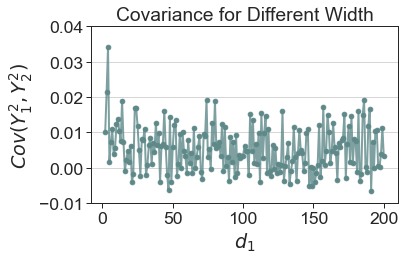

  0%|          | 0/199 [00:00<?, ?it/s]

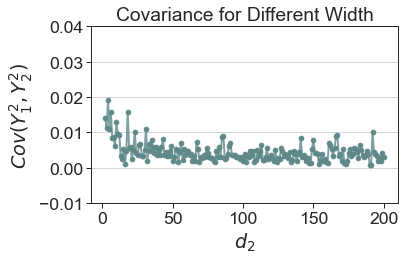

  0%|          | 0/199 [00:00<?, ?it/s]

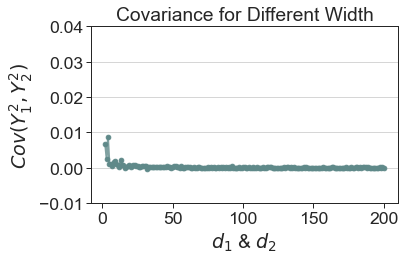

In [32]:
layer_to_inf_list = ['hid_1', 'hid_2', 'both']
width_seq = np.arange(2, 201)

plot_covariance_of_last_hid_multi_nn(layer_to_inf_list, width_seq)